See https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf for more information about 1d convolutions and time series classification

In [1]:
# Check if tensorflow finds the runtime GPU
import tensorflow as tf


print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

2.8.2
Found GPU at: /device:GPU:0


In [2]:
# Clone the repository

Cloning into 'fc_crash-detection'...
remote: Enumerating objects: 18779, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 18779 (delta 13), reused 9 (delta 4), pack-reused 18749
Receiving objects: 100% (18779/18779), 2.00 GiB | 18.26 MiB/s, done.
Resolving deltas: 100% (835/835), done.
Checking out files: 100% (16051/16051), done.


In [ ]:
# Mount Google Drive
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set params
dataset_path = '/content/fc_crash-detection/crash-dataset-csv/microbox'
test_dataset_path = '/content/drive/MyDrive/data_aug_dataset/microbox' # Where to save test set
results_path = '/content/drive/MyDrive'
model_name = 'microbox_fft_xyz_300_data_aug_1' # In results_path
mode = "fft" # time or fft
test_split = 0.2
validation_split = 0.1
max_epoch = 1000
min_delta = 0
patience = 60

In [4]:
# Define some functions
from tqdm.notebook import tqdm
from scipy.fft import fft
import numpy as np
import pandas as pd
import glob
import os


def preprocess_microbox(entry):
  loaded_entry = entry.values[1:3000,4:7]
  #numpy slicing [start:stop:step]
  loaded_entry_subsamp = loaded_entry[::10].copy()

  return loaded_entry_subsamp


def get_dataset(path):

  entry_list = []

  files_list = glob.glob(os.path.join(path, "*.csv"))
  # Load every csv inside path as a numpy matrix, preprocess and create a list
  for filename in tqdm(files_list):
    ds_entry = pd.read_csv(filename, index_col=None, header=0)
    ds_entry_processed = preprocess_microbox(ds_entry)
    entry_list.append(ds_entry_processed)

  # Convert list to a numpy array. Cast to float32 to avoid errors on fit
  ds_array = np.asarray(entry_list).astype('float32')

  return ds_array

In [5]:
# Define the rotations matrices for data augmentation
import numpy as np
import math as m

 
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
 
def Ry(theta):
  return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
 
def Rz(theta):
  return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

steps = 181 # Equal steps between -max angle to +max angle (including angle 0)
angle = m.pi/4 # +/-max angle
rotations = 10 # Number of rotations to use for training set data augmentation

R = []
for i in range(-int((steps - 1)/2), int((steps - 1)/2) + 1):
  a = i*angle*(1/((steps - 1)/2))
  for j in range(-int((steps - 1)/2), int((steps - 1)/2) + 1):
    b = j*angle*(1/((steps - 1)/2))
    for z in range(-int((steps - 1)/2), int((steps - 1)/2) + 1):
      c = z*angle*(1/((steps - 1)/2))
      if not (a == 0 and b == 0 and c == 0):
        R_ = Rz(a) * Ry(b) * Rx(c)
        R.append(R_)
print("Number of combinations: " + str(len(R) + 1))

Number of combinations: 5929741


In [6]:
# Load data
ds_false_init = get_dataset(dataset_path + '/false')
ds_true_init = get_dataset(dataset_path + '/true')

print("\nFalse-class data:")
print(ds_false_init.shape)

print("\nTrue-class data:")
print(ds_false_init.shape)

  0%|          | 0/962 [00:00<?, ?it/s]

  0%|          | 0/962 [00:00<?, ?it/s]


False-class data:
(962, 300, 3)

True-class data:
(962, 300, 3)


In [7]:
# Train test split
import numpy as np
import random
from sklearn.model_selection import train_test_split


ds_false_train, X_test_false = train_test_split(ds_false_init, test_size = test_split)
ds_true_train, X_test_true = train_test_split(ds_true_init, test_size = test_split)

# Series rotation for ds_false test
ds_aug = X_test_false[0,:,:].copy()
ds_false_aug = []
for j in range(0, X_test_false.shape[0]):
  n = random.randint(0,len(R))
  if n == len(R): # Null rotation
    ds_aug = X_test_false[j,:,:]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
  else: # Apply rotation
    for i in range(0, X_test_false.shape[1]):
      v1 = np.array([[X_test_false[j,i,0]],[X_test_false[j,i,1]],[X_test_false[j,i,2]]])
      v2 = R[n] * v1
      ds_aug[i, 0] = v2[0,0]
      ds_aug[i, 1] = v2[1,0]
      ds_aug[i, 2] = v2[2,0]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)

  if mode == "fft":
    ds_false_aug.append(ds_entry_fft)
  if mode == "time":
    ds_false_aug.append(ds_aug)
# Convert list to a numpy array
ds_false = np.asarray(ds_false_aug).astype('float32')

# Series rotation for ds_true test
ds_aug = X_test_true[0,:,:].copy()
ds_true_aug = []
for j in range(0, X_test_true.shape[0]):
  n = random.randint(0,len(R))
  if n == len(R): # Null rotation
    ds_aug = X_test_true[j,:,:]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
  else: # Apply rotation
    for i in range(0, X_test_true.shape[1]):
      v1 = np.array([[X_test_true[j,i,0]],[X_test_true[j,i,1]],[X_test_true[j,i,2]]])
      v2 = R[n] * v1
      ds_aug[i, 0] = v2[0,0]
      ds_aug[i, 1] = v2[1,0]
      ds_aug[i, 2] = v2[2,0]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)

  if mode == "fft":
    ds_true_aug.append(ds_entry_fft)
  if mode == "time":
    ds_true_aug.append(ds_aug)
# Convert list to a numpy array
ds_true = np.asarray(ds_true_aug).astype('float32')

# Build all-false labels (one hot encoding, two classes, two columns)
ds_false_labels = np.zeros((len(ds_false),2))
# Set all first column to one
ds_false_labels[:,0] = 1
print("False-class test data:")
print(ds_false.shape)
print(ds_false_labels.shape)

# Build all-true labels (one hot encoding, two classes, two columns)
ds_true_labels = np.zeros((len(ds_true),2))
# Set all second column to one
ds_true_labels[:,1] = 1
print("\nTrue-class test data:")
print(ds_true.shape)
print(ds_true_labels.shape)

X_test = np.concatenate((ds_false, ds_true), axis = 0)
y_test = np.concatenate((ds_false_labels, ds_true_labels), axis = 0)
print("\nAll test data:")
print(X_test.shape)
print(y_test.shape)

# Train validation split
ds_false_no_aug, X_val_false = train_test_split(ds_false_train, test_size = validation_split)
ds_true_no_aug, X_val_true = train_test_split(ds_true_train, test_size = validation_split)

# Series rotation for ds_false validation
ds_aug = X_val_false[0,:,:].copy()
ds_false_aug = []
for j in range(0, X_val_false.shape[0]):
  n = random.randint(0,len(R))
  if n == len(R): # Null rotation
    ds_aug = X_val_false[j,:,:]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
  else: # Apply rotation
    for i in range(0, X_val_false.shape[1]):
      v1 = np.array([[X_val_false[j,i,0]],[X_val_false[j,i,1]],[X_val_false[j,i,2]]])
      v2 = R[n] * v1
      ds_aug[i, 0] = v2[0,0]
      ds_aug[i, 1] = v2[1,0]
      ds_aug[i, 2] = v2[2,0]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)

  if mode == "fft":
    ds_false_aug.append(ds_entry_fft)
  if mode == "time":
    ds_false_aug.append(ds_aug)
# Convert list to a numpy array
ds_false = np.asarray(ds_false_aug).astype('float32')

# Series rotation for ds_true validation
ds_aug = X_val_true[0,:,:].copy()
ds_true_aug = []
for j in range(0, X_val_true.shape[0]):
  n = random.randint(0,len(R))
  if n == len(R): # Null rotation
    ds_aug = X_val_true[j,:,:]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
  else: # Apply rotation
    for i in range(0, X_val_true.shape[1]):
      v1 = np.array([[X_val_true[j,i,0]],[X_val_true[j,i,1]],[X_val_true[j,i,2]]])
      v2 = R[n] * v1
      ds_aug[i, 0] = v2[0,0]
      ds_aug[i, 1] = v2[1,0]
      ds_aug[i, 2] = v2[2,0]

    if mode == "fft": # If mode fft, apply fast Fourier transform

      fft_x = fft(ds_aug[:,0])
      fft_y = fft(ds_aug[:,1])
      fft_z = fft(ds_aug[:,2])

      d_x = np.absolute(fft_x)
      d_y = np.absolute(fft_y)
      d_z = np.absolute(fft_z)

      ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
      
  if mode == "fft":
    ds_true_aug.append(ds_entry_fft)
  if mode == "time":
    ds_true_aug.append(ds_aug)
# Convert list to a numpy array
ds_true = np.asarray(ds_true_aug).astype('float32')

# Build all-false labels (one hot encoding, two classes, two columns)
ds_false_labels = np.zeros((len(ds_false),2))
# Set all first column to one
ds_false_labels[:,0] = 1
print("\nFalse-class validation data:")
print(ds_false.shape)
print(ds_false_labels.shape)

# Build all-true labels (one hot encoding, two classes, two columns)
ds_true_labels = np.zeros((len(ds_true),2))
# Set all second column to one
ds_true_labels[:,1] = 1
print("\nTrue-class validation data:")
print(ds_true.shape)
print(ds_true_labels.shape)

# Concatenate false-class/true-class data and labels
X_val = np.concatenate((ds_false, ds_true), axis = 0)
y_val = np.concatenate((ds_false_labels, ds_true_labels), axis = 0)
print("\nAll validation data:")
print(X_val.shape)
print(y_val.shape)

# Data augmentation for ds_false train
ds_aug = ds_false_no_aug[0,:,:].copy()
ds_false_aug = []
for j in range(0, ds_false_no_aug.shape[0]):
  randomlist = []
  while len(randomlist) < rotations: # Fill with random rotations
    n = random.randint(0,len(R))
    if n not in randomlist:
      randomlist.append(n)
  for k in range (0, len(randomlist)):
    if randomlist[k] == len(R): # Null rotation
      ds_aug = ds_false_no_aug[j,:,:]

      if mode == "fft": # If mode fft, apply fast Fourier transform

        fft_x = fft(ds_aug[:,0])
        fft_y = fft(ds_aug[:,1])
        fft_z = fft(ds_aug[:,2])

        d_x = np.absolute(fft_x)
        d_y = np.absolute(fft_y)
        d_z = np.absolute(fft_z)

        ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
    else: # Apply rotations
      for i in range(0, ds_false_no_aug.shape[1]):
        v1 = np.array([[ds_false_no_aug[j,i,0]],[ds_false_no_aug[j,i,1]],[ds_false_no_aug[j,i,2]]])
        v2 = R[randomlist[k]] * v1
        ds_aug[i, 0] = v2[0,0]
        ds_aug[i, 1] = v2[1,0]
        ds_aug[i, 2] = v2[2,0]

      if mode == "fft": # If mode fft, apply fast Fourier transform

        fft_x = fft(ds_aug[:,0])
        fft_y = fft(ds_aug[:,1])
        fft_z = fft(ds_aug[:,2])

        d_x = np.absolute(fft_x)
        d_y = np.absolute(fft_y)
        d_z = np.absolute(fft_z)

        ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)

    if mode == "fft":
      ds_false_aug.append(ds_entry_fft)
    if mode == "time":
      ds_false_aug.append(ds_aug)
# Convert list to a numpy array. Cast to float32 to avoid errors on fit
ds_false = np.asarray(ds_false_aug).astype('float32')

# Data augmentation for ds_true train
ds_aug = ds_true_no_aug[0,:,:].copy()
ds_true_aug = []
for j in range(0, ds_true_no_aug.shape[0]):     
  randomlist = []
  while len(randomlist) < rotations: # Fill with random rotations
    n = random.randint(0,len(R))
    if n not in randomlist:
      randomlist.append(n)
  for k in range (0, len(randomlist)):
    if randomlist[k] == len(R): # Null rotation
      ds_aug = ds_true_no_aug[j,:,:]

      if mode == "fft": # If mode fft, apply fast Fourier transform

        fft_x = fft(ds_aug[:,0])
        fft_y = fft(ds_aug[:,1])
        fft_z = fft(ds_aug[:,2])

        d_x = np.absolute(fft_x)
        d_y = np.absolute(fft_y)
        d_z = np.absolute(fft_z)

        ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)
    else: # Apply rotations
      for i in range(0, ds_true_no_aug.shape[1]):
        v1 = np.array([[ds_true_no_aug[j,i,0]],[ds_true_no_aug[j,i,1]],[ds_true_no_aug[j,i,2]]])
        v2 = R[randomlist[k]] * v1
        ds_aug[i, 0] = v2[0,0]
        ds_aug[i, 1] = v2[1,0]
        ds_aug[i, 2] = v2[2,0]

      if mode == "fft": # If mode fft, apply fast Fourier transform

        fft_x = fft(ds_aug[:,0])
        fft_y = fft(ds_aug[:,1])
        fft_z = fft(ds_aug[:,2])

        d_x = np.absolute(fft_x)
        d_y = np.absolute(fft_y)
        d_z = np.absolute(fft_z)

        ds_entry_fft = np.stack([d_x, d_y, d_z], axis=1)

    if mode == "fft":
      ds_true_aug.append(ds_entry_fft)
    if mode == "time":
      ds_true_aug.append(ds_aug)
# Convert list to a numpy array. Cast to float32 to avoid errors on fit
ds_true = np.asarray(ds_true_aug).astype('float32')

# Build all-false labels (one hot encoding, two classes, two columns)
ds_false_labels = np.zeros((len(ds_false),2))
# Set all first column to one
ds_false_labels[:,0] = 1
print("\nFalse-class train data:")
print(ds_false.shape)
print(ds_false_labels.shape)

# Build all-true labels (one hot encoding, two classes, two columns)
ds_true_labels = np.zeros((len(ds_true),2))
# Set all second column to one
ds_true_labels[:,1] = 1
print("\nTrue-class train data:")
print(ds_true.shape)
print(ds_true_labels.shape)

# Concatenate false-class/true-class data and labels
X_train = np.concatenate((ds_false, ds_true), axis = 0)
y_train = np.concatenate((ds_false_labels, ds_true_labels), axis = 0)
print("\nAll train data:")
print(X_train.shape)
print(y_train.shape)
del ds_false_train, ds_true_train, ds_false_no_aug, ds_true_no_aug, ds_false, ds_true, ds_false_labels, ds_true_labels, ds_aug, ds_false_aug, ds_true_aug

False-class test data:
(193, 300, 3)
(193, 2)

True-class test data:
(193, 300, 3)
(193, 2)

All test data:
(386, 300, 3)
(386, 2)

False-class validation data:
(77, 300, 3)
(77, 2)

True-class validation data:
(77, 300, 3)
(77, 2)

All validation data:
(154, 300, 3)
(154, 2)

False-class train data:
(6920, 300, 3)
(6920, 2)

True-class train data:
(6920, 300, 3)
(6920, 2)

All train data:
(13840, 300, 3)
(13840, 2)


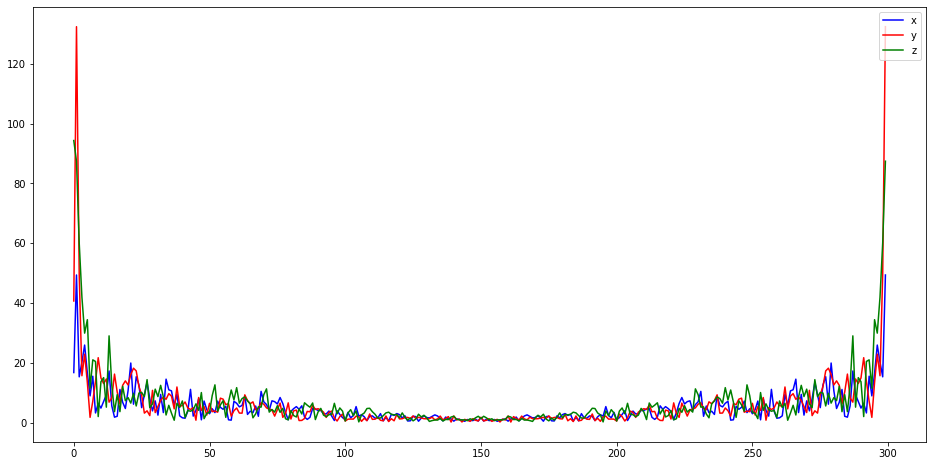

In [17]:
# Plot a single sample of data
from matplotlib import pyplot as plt
import numpy as np
import random


sample = random.randint(0, X_train.shape[0])
x = np.arange(0,len(X_train[sample]))

fig = plt.figure(figsize=(16,8))
plt.plot(x, X_train[sample,:,0], "blue", label="x")
plt.plot(x, X_train[sample,:,1], "red", label="y")
plt.plot(x, X_train[sample,:,2], "green", label="z")
plt.legend(loc="upper right")
plt.show()

In [18]:
# Create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D


# Model definition
model = tf.keras.models.Sequential()

input_shape=(X_train.shape[1],X_train.shape[2])
model.add(Conv1D(100, 10, activation='relu', input_shape=input_shape))
#model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(20))
model.add(Dropout(0.2))
model.add(Conv1D(50, 2, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.1))
model.add(Conv1D(25, 2, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Define optimizer, learning rate, and compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'AUC'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 291, 100)          3100      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 100)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 50)            10050     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 50)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0

Epoch 1/1000
433/433 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.6436 - auc: 0.6955
Epoch 1: val_accuracy improved from -inf to 0.72078, saving model to /content/microbox_fft_xyz_300_data_aug_1.h5
433/433 [==============================] - 16s 7ms/step - loss: 0.6644 - accuracy: 0.6436 - auc: 0.6955 - val_loss: 0.6490 - val_accuracy: 0.7208 - val_auc: 0.8097
Epoch 2/1000
430/433 [============================>.] - ETA: 0s - loss: 0.5445 - accuracy: 0.7416 - auc: 0.8165
Epoch 2: val_accuracy improved from 0.72078 to 0.72727, saving model to /content/microbox_fft_xyz_300_data_aug_1.h5
433/433 [==============================] - 3s 8ms/step - loss: 0.5439 - accuracy: 0.7421 - auc: 0.8170 - val_loss: 0.7384 - val_accuracy: 0.7273 - val_auc: 0.8147
Epoch 3/1000
432/433 [============================>.] - ETA: 0s - loss: 0.4897 - accuracy: 0.7863 - auc: 0.8576
Epoch 3: val_accuracy improved from 0.72727 to 0.81169, saving model to /content/microbox_fft_xyz_300_data_a

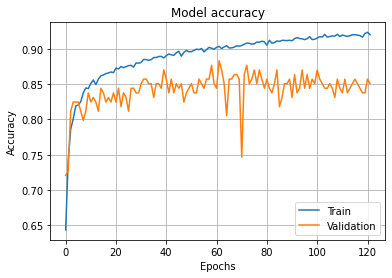

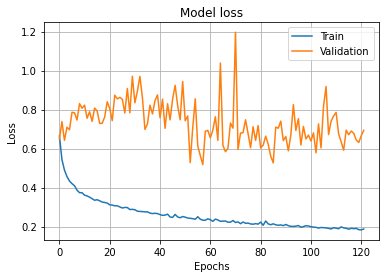

In [19]:
# Train
from matplotlib import pyplot as plt
import tensorflow as tf


checkpoint = tf.keras.callbacks.ModelCheckpoint(results_path + '/' + model_name + '.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=min_delta, patience=patience, verbose=1, mode='auto')

history = model.fit(X_train, y_train, validation_data = [X_val, y_val], epochs = max_epoch, callbacks = [checkpoint, early], shuffle = True)

# Accuracy
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
fig1.savefig(results_path + '/' + model_name + '_model_accuracy.png')
plt.show()
# Loss
fig2 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
fig2.savefig(results_path + '/' + model_name + '_model_loss.png')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 291, 100)          3100      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 100)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 50)            10050     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 50)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0

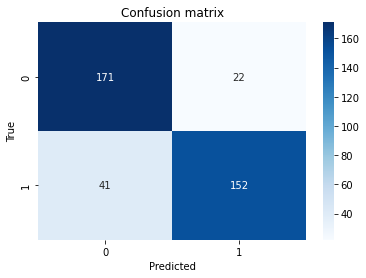

In [20]:
# Test
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from tensorflow import keras
import seaborn as sns
import pandas as pd


model = keras.models.load_model(results_path + '/' + model_name + '.h5')
model.summary()
results = model.evaluate(X_test, y_test)

print('\nTest Loss, Test Accuracy, Test AUC:', results)

# Generate confusion matrix and compute metrics
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred)
tn, fp, fn, tp = conf_mat.ravel()
precision = precision_score(y_test.argmax(axis=1), y_pred)
recall = recall_score(y_test.argmax(axis=1), y_pred)
f1_score = f1_score(y_test.argmax(axis=1), y_pred)

print('\nPrecision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(f1_score))
print('\nTrue Negatives: ' + str(tn))
print('False Positives: ' + str(fp))
print('False Negatives: ' + str(fn))
print('True Positives: ' + str(tp) + '\n')

fig = plt.figure()
sns.heatmap(conf_mat, annot=True, fmt="d",cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
fig.savefig(results_path + '/' + model_name + '_confusion_matrix.png')
plt.show()

data = {'a': [results[0], results[1], results[2], precision, recall, f1_score, tn, fp, fn, tp]}
df = pd.DataFrame(data=data, index=['Test Loss', 'Test Accuracy', 'Test AUC', 'Precision', 'Recall', 'F1-score', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives'])
df.to_csv(results_path + '/' + model_name + '_results.csv', header=False)

In [23]:
# Save test dataset
import csv
import os


if len(os.listdir(test_dataset_path + '/false')) == 0 and len(os.listdir(test_dataset_path + '/true')) == 0:
  for i in range(0,len(X_test)):
    if y_test[i][1] == 1:
      test_class = "true"
    else:
      test_class = "false"
    with open(test_dataset_path + '/' + test_class + '/' + test_class + '_' + str(i+1) + '.csv', 'w') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(["","",""])
      for j in range(0, len(X_test[0])):
        writer.writerow([str(X_test[i][j][0]), str(X_test[i][j][1]), str(X_test[i][j][2])])
      writer.writerow(["", "", ""])